<a href="https://colab.research.google.com/github/ceroytres/kornia-examples/blob/zca/zca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ZCA Whitening

The following tutorial will show you how to perform ZCA data whitening on a dataset using ```kornia.enhance.zca```. The documentation for ZCA whitening can be found [here](https://kornia.readthedocs.io/en/latest/enhance.html#kornia.enhance.ZCAWhitening).

## Install necessary packages

In [ ]:
!pip install git+https://github.com/ceroytres/kornia.git numpy matplotlib

  Cloning https://github.com/ceroytres/kornia.git to /tmp/pip-req-build-7_cmzus3
  Running command git clone -q https://github.com/ceroytres/kornia.git /tmp/pip-req-build-7_cmzus3
  Created wheel for kornia: filename=kornia-0.4.1+399bd57-py2.py3-none-any.whl size=211317 sha256=78b1f48788b02053750f64973b13a68cbe1b0ff30dc4aa9cef93f56bb1b9fe46
  Stored in directory: /tmp/pip-ephem-wheel-cache-sub2pn81/wheels/42/eb/68/8417f608e3c12435b09762c42f1923d8778582a61b7e3c55a7
Successfully built kornia


In [ ]:
#Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import kornia

from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [ ]:
# Select runtime device
device = torch.device('cpu')
print(f"Using {device}")

Using cpu


Download and load MNIST dataset.

In [ ]:
dataset = datasets.MNIST('./data/mnist', train=True, download=True, 
                         transform=transforms.Compose([transforms.ToTensor()])) 

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Stack whole dataset in order to fit ZCA on whole dataset.

In [ ]:
images = []
for i in range(len(dataset)):
  im, _ = dataset[i]
  images.append(im) 
images = torch.stack(images, dim = 0).to(device)

Create an ZCA object and fit the transformation in the forward pass. Setting ```include_fit``` is necessary if you need to include the ZCA fitting processing the backwards pass.

In [ ]:
zca = kornia.enhance.ZCAWhitening(eps=0.1)
images_zca = zca(images, include_fit = True)

The result shown should enhance the edges of the MNIST digits because the regularization parameter $\epsilon$ increases the importance of the higher frequencies which typically correspond to the lowest eigenvalues in ZCA. The result looks similar to the demo from the [Stanford ZCA tutorial](http://ufldl.stanford.edu/tutorial/unsupervised/ExercisePCAWhitening/)

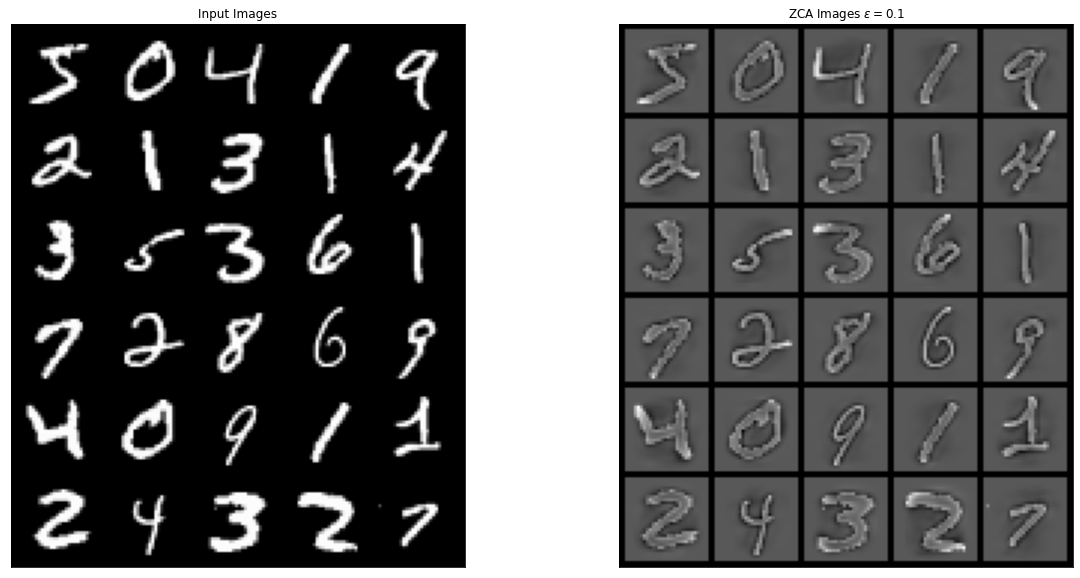

In [ ]:
grid_im = make_grid(images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_zca = make_grid(images_zca[0:30], nrow=5, normalize=True).cpu().numpy()


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(grid_im,[1,2,0]))
plt.title('Input Images')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(np.transpose(grid_zca,[1,2,0]))
plt.title(r'ZCA Images $\epsilon = 0.1$')
plt.xticks([])
plt.yticks([])
plt.show()

In the next example, we explore using ZCA on the CIFAR 10, which is a dataset of color images (e.g 4-D tensor $[B, C, H, W]$). In the cell below, we prepare the dataset.

In [ ]:
dataset = datasets.CIFAR10('./data/cifar', train=True, download=True, 
                         transform=transforms.Compose([transforms.ToTensor()]))
images = []
for i in range(len(dataset)):
  im, _ = dataset[i]
  images.append(im) 
images = torch.stack(images, dim = 0).to(device) 

Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar



We show another way to fit the ZCA transform. The argument ```detach_transforms``` detaches the fitting of the transforms from the backwards pass in case you do not need to the gradients from the fitting process. ```compute_inv``` enables the computation of inverse ZCA transform.

In [ ]:
zca = kornia.enhance.ZCAWhitening(eps=0.1, detach_transforms=True,
                                      compute_inv=True)
zca.fit(images)
zca_images = zca(images)
image_re = zca.inverse_transform(zca_images)

Note how the higher frequency details are more present in the ZCA normalized images for CIFAR-10 dataset.

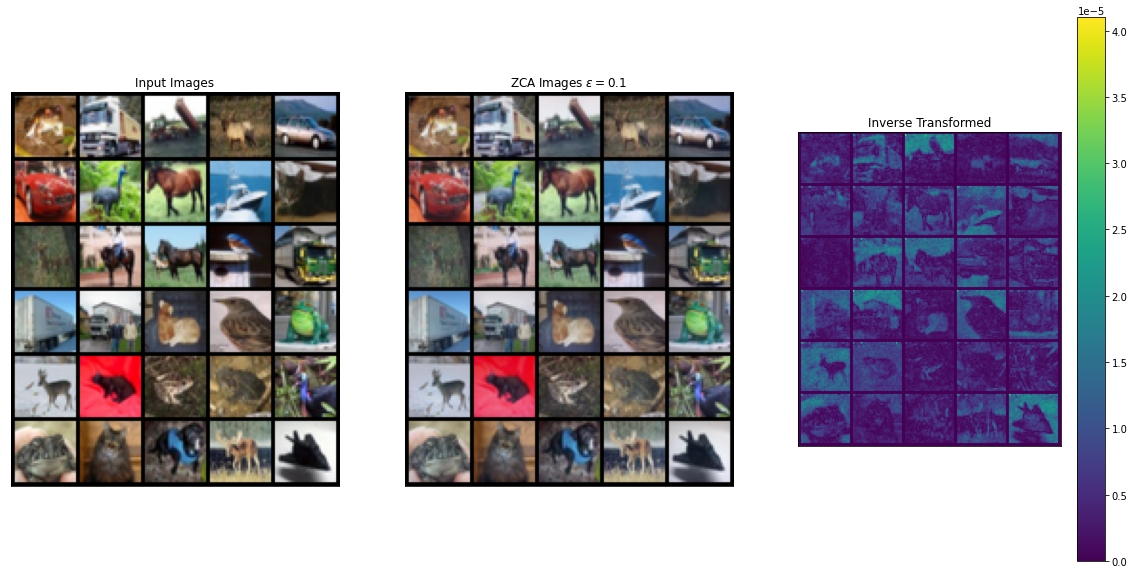

In [ ]:
grid_im = make_grid(images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_zca = make_grid(zca_images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_re= make_grid(image_re[0:30], nrow=5, normalize=True).cpu().numpy()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.transpose(grid_im,[1,2,0]))
plt.title('Input Images')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(np.transpose(grid_zca,[1,2,0]))
plt.title(r'ZCA Images $\epsilon = 0.1$')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(np.sum(abs(np.transpose(grid_re,[1,2,0]) - np.transpose(grid_im,[1,2,0])), axis = -1))
plt.colorbar()
plt.title(r'Inverse Transformed')
plt.xticks([])
plt.yticks([])
plt.show()